# Experiment on AAI Model Architectures
- Created: 10 Mar 2020
- Data: param_draft2
- Increase data size and change model architecture
- Pre SE
- expeirment 12 13

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from os.path import join
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import callbacks
from time import time
from datetime import datetime
import shutil 
import argparse
from functools import partial
import pickle
from IPython.display import Audio

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Reshape, GRU, InputLayer, AlphaDropout, Activation, BatchNormalization, Dropout, Flatten, Dense, Bidirectional, LSTM, Conv1D, SpatialDropout1D, Concatenate, Multiply, Add

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

In [2]:
np_load_old = partial(np.load)
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [3]:
tf.random.set_seed(42)

## Metric Function

In [4]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

def R2(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred), axis = 0) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true, axis = 0)), axis = 0) 
    return K.mean(1 - (SS_res/SS_tot), axis=0)

## Utility Functions

In [5]:
#Function for preprocessing data
def delete_params(params):
    '''
    This function remove JX, WC, TRX, TRY, and MS1,2,3 paramter
    '''
    DEL_PARAMS_LIST = [2,8,15,16,21,22,23]
    return np.delete(params,DEL_PARAMS_LIST , axis=1)

In [6]:
def compute_rmse(actual,pred, axis=1):
    # Compute RMSE by row (axis=1) result in rmse of each data
    # Compute RMSE by column (axis=0) result in rmse of each label
    return np.sqrt((np.square(actual - pred)).mean(axis=axis))

In [7]:
def evaluate_model(y_pred, label):
    y_pred = enc.inverse_transform(y_pred)
    label = enc.inverse_transform(label)
#     print('Confusion Matrix')
#     print(confusion_matrix(label, y_pred))
    print('Classification Report')
    print(classification_report(label, y_pred))

In [8]:
def compute_se(actual,pred):
    return np.sqrt((np.square(actual - pred)))

## Load Data 

In [9]:
def prep_data():

    # load data from preprocess pipeline
    dataset = np.load(join('../../data/d_dataset_p2/prep_data_13','training_subsets.npz'))
    X_train =dataset['X_train']
    y_train= dataset['y_train']
    z_train= dataset['z_train']
    X_val = dataset['X_val']
    y_val = dataset['y_val']
    z_val = dataset['z_val']
    X_test = dataset['X_test']
    y_test = dataset['y_test']
    z_test = dataset['z_test']
    a_test = dataset['audio_test']
    a_val = dataset['audio_val']
    
    y_train = delete_params(y_train)
    y_val = delete_params(y_val)
    y_test = delete_params(y_test)

    print('Train features and labels %s %s'%(str(X_train.shape),str(y_train.shape)))
    print('Validating features and labels %s %s'%(str(X_val.shape),str(y_val.shape)))
    print('Test features and labels %s %s'%(str(X_test.shape),str(y_test.shape)))

    return X_train, X_val, X_test, y_train, y_val, y_test, z_train, z_val, z_test, a_test, a_val

In [10]:
X_train, X_val, X_test, y_train, y_val, y_test, z_train, z_val, z_test, a_test, a_val = prep_data()

Train features and labels (76260, 24, 39) (76260, 17)
Validating features and labels (9340, 24, 39) (9340, 17)
Test features and labels (9338, 24, 39) (9338, 17)


In [11]:
print(set(z_test))

{'E', 'u', '@', '2', 'A', 'e', 'E:', 'U', 'a', 'o', 'i', 'O', 'y', '9'}


In [12]:
print('Train features and labels {} {} {}'.format(str(X_train.shape),str(y_train.shape),str(z_train.shape)))
print('Validating features and labels {} {} {}'.format(str(X_val.shape),str(y_val.shape),str(z_val.shape)))
print('Test features and labels {} {} {}'.format(str(X_test.shape),str(y_test.shape),str(z_test.shape)))

Train features and labels (76260, 24, 39) (76260, 17) (76260,)
Validating features and labels (9340, 24, 39) (9340, 17) (9340,)
Test features and labels (9338, 24, 39) (9338, 17) (9338,)


### One-hot label 

In [13]:
z_train_oe=z_train.reshape(-1,1)
z_val_oe=z_val.reshape(-1,1)
z_test_oe=z_test.reshape(-1,1)

enc = OneHotEncoder(handle_unknown = 'ignore')
enc.fit(z_train_oe)

z_train_oe = enc.transform(z_train_oe).toarray()
z_test_oe = enc.transform(z_test_oe).toarray()
z_val_oe = enc.transform(z_val_oe).toarray()

## 1.) Train Baseline Model
- Model without embedding feature

### Defined Model without Embedded Feature

In [14]:
N_OUTPUTS = 17

pLSTM = partial(LSTM, kernel_initializer='he_uniform', return_sequences=True)
pConv1D = partial(Conv1D, padding = 'same', activation = 'linear', kernel_initializer = 'he_uniform')

def init_senet(feature_layer=1, cnn_unit=128, first_kernel=13, res_unit=128, res_kernel=7,
    bilstm = 1, bilstm_unit=256, 
    dropout_rate=0.3,
    reduction_ratio = 2,
    activation_fn='relu'):


    def cnn_block(input_x, cnn_unit, kernel_size):
        x = pConv1D(cnn_unit, kernel_size=kernel_size)(input_x)
        x = BatchNormalization()(x)
        x = Activation(activation_fn)(x)
        return x
    
    def residual_block(input_x):
        x = pConv1D(res_unit, kernel_size=res_kernel)(input_x)
        x = BatchNormalization()(x)
        x = Activation(activation_fn)(x)
        x = pConv1D(res_unit, kernel_size=res_kernel)(x)
        x = BatchNormalization()(x)
        x = keras.layers.Add()([x, input_x])
        output = Activation(activation_fn)(x)
        return output

    def se_block(input_x):
        x = layers.GlobalAveragePooling1D()(input_x)
        channel_shape = getattr(x, '_shape_val')[-1]
        x = Reshape((1, channel_shape))(x)
        x = Dense(channel_shape // reduction_ratio, activation=activation_fn, kernel_initializer='he_uniform')(x)
        x = Dense(channel_shape, activation='tanh', kernel_initializer='he_uniform')(x)
        return x

    def se_res_block(input_x):
        se_x = se_block(input_x)
        x = layers.Multiply()([input_x, se_x])
        x = residual_block(x)
        return x

    def senet_nn(input_shape_1,input_shape_2):

        input_x = keras.Input(shape=(input_shape_1,input_shape_2))
        x = cnn_block(input_x, cnn_unit, first_kernel)
        for i in range(feature_layer):
            x = se_res_block(x)
        x = SpatialDropout1D(rate=dropout_rate)(x)
        for i in range(feature_layer):
            x = se_res_block(x)
            x = SpatialDropout1D(rate=dropout_rate)(x)
        x = cnn_block(x, cnn_unit=cnn_unit, kernel_size=1)
        x = SpatialDropout1D(rate=dropout_rate)(x)
        for i in range(bilstm-1):
            x = Bidirectional(pLSTM(bilstm_unit))(x)
            x = SpatialDropout1D(rate=dropout_rate)(x)
        x = Bidirectional(pLSTM(bilstm_unit, return_sequences=False))(x)
        x = Dropout(rate=dropout_rate)(x)
        outputs = Dense(N_OUTPUTS, activation='linear', kernel_initializer='he_uniform')(x)
        model = keras.Model(inputs=input_x, outputs=outputs)
        return model

    return senet_nn

In [15]:
model = init_senet()(24, 39)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24, 39)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 24, 128)      65024       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 24, 128)      512         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 24, 128)      0           batch_normalization[0][0]        
______________________________________________________________________________________________

### Compile Model 

In [17]:
model.compile(optimizer='adam',loss='mse',metrics=[rmse, R2])

### Train Model 

In [18]:
PATIENCE = 10
BATCH_SIZE = 128
EPOCHS = 100

early = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=PATIENCE, verbose=1, mode='min', baseline=None, restore_best_weights=False)
callback_list = [early]

In [19]:
history = model.fit(X_train,y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val,y_val),
    callbacks=callback_list)

Train on 76260 samples, validate on 9340 samples
Epoch 1/100
76260/76260 [==============================] - 27s 360us/sample - loss: 0.0896 - rmse: 0.2758 - R2: 0.6365 - val_loss: 0.0391 - val_rmse: 0.1813 - val_R2: 0.8427
Epoch 2/100
76260/76260 [==============================] - 18s 230us/sample - loss: 0.0525 - rmse: 0.2105 - R2: 0.7877 - val_loss: 0.0347 - val_rmse: 0.1701 - val_R2: 0.8601
Epoch 3/100
76260/76260 [==============================] - 18s 231us/sample - loss: 0.0465 - rmse: 0.1972 - R2: 0.8122 - val_loss: 0.0318 - val_rmse: 0.1643 - val_R2: 0.8713
Epoch 4/100
76260/76260 [==============================] - 18s 232us/sample - loss: 0.0434 - rmse: 0.1901 - R2: 0.8245 - val_loss: 0.0301 - val_rmse: 0.1594 - val_R2: 0.8779
Epoch 5/100
76260/76260 [==============================] - 18s 230us/sample - loss: 0.0414 - rmse: 0.1853 - R2: 0.8327 - val_loss: 0.0302 - val_rmse: 0.1582 - val_R2: 0.8772
Epoch 6/100
76260/76260 [==============================] - 18s 230us/sample - los

In [20]:
model.save('model_baseline.hdf5')

### Evaluation 

In [21]:
model.evaluate(X_test,y_test,verbose=0)

[0.02214339342503674, 0.13358897, 0.90401524]

In [22]:
y_pred = model.predict(X_test)

In [23]:
err = compute_rmse(y_test,y_pred, axis=0)

In [24]:
print(err)

[0.15131707 0.12680595 0.12171652 0.13883751 0.14916609 0.18558254
 0.20481043 0.09804399 0.11042881 0.14687408 0.15451697 0.1364162
 0.13520527 0.18700868 0.14672336 0.14532703 0.15154928]


## 2.) Trained Embedding Layer 

### Defined Embedding Model

In [25]:
PHONETIC_OUTPUT = len(set(z_train))
EMBEDDED_FEATURE = 128

pLSTM = partial(LSTM, kernel_initializer='he_uniform', return_sequences=True)

def embeded_model(input_shape_1,input_shape_2):
    inputs = keras.Input(shape=(input_shape_1,input_shape_2))
    x = pLSTM(64, return_sequences=False)(inputs)
    Dense(EMBEDDED_FEATURE, activation='sigmoid', kernel_initializer='he_uniform')(x)
    outputs = Dense(PHONETIC_OUTPUT, activation='softmax', kernel_initializer='he_uniform')(x)
    return keras.Model(inputs=inputs, outputs=outputs)

In [26]:
embedded = embeded_model(24, 39)
embedded.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 24, 39)]          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                26624     
_________________________________________________________________
dense_6 (Dense)              (None, 14)                910       
Total params: 27,534
Trainable params: 27,534
Non-trainable params: 0
_________________________________________________________________


### Compile Model 

In [27]:
embedded.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

### Train Model 

In [28]:
PATIENCE = 10
BATCH_SIZE = 128
EPOCHS = 100

early = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=PATIENCE, verbose=1, mode='min', baseline=None, restore_best_weights=False)
callback_list = [early]

In [29]:
history = embedded.fit(X_train,z_train_oe,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val,z_val_oe),
    callbacks=callback_list)

Train on 76260 samples, validate on 9340 samples
Epoch 1/100
76260/76260 [==============================] - 5s 71us/sample - loss: 2.0958 - accuracy: 0.7063 - val_loss: 1.9013 - val_accuracy: 0.8675
Epoch 2/100
76260/76260 [==============================] - 3s 39us/sample - loss: 1.9206 - accuracy: 0.8484 - val_loss: 1.8615 - val_accuracy: 0.9006
Epoch 3/100
76260/76260 [==============================] - 3s 40us/sample - loss: 1.8885 - accuracy: 0.8757 - val_loss: 1.8475 - val_accuracy: 0.9134
Epoch 4/100
76260/76260 [==============================] - 3s 39us/sample - loss: 1.8722 - accuracy: 0.8900 - val_loss: 1.8419 - val_accuracy: 0.9175
Epoch 5/100
76260/76260 [==============================] - 3s 39us/sample - loss: 1.8626 - accuracy: 0.8981 - val_loss: 1.8372 - val_accuracy: 0.9208
Epoch 6/100
76260/76260 [==============================] - 3s 39us/sample - loss: 1.8555 - accuracy: 0.9046 - val_loss: 1.8346 - val_accuracy: 0.9227
Epoch 7/100
76260/76260 [==========================

In [30]:
embedded.save('embedded.hdf5')

### Evaluated Model 

In [31]:
z_pred = embedded.predict(X_test)
evaluate_model(z_pred, z_test_oe)

Classification Report
              precision    recall  f1-score   support

           2       0.94      0.97      0.96       701
           9       0.98      0.97      0.98       688
           @       0.97      0.97      0.97       635
           A       0.93      0.97      0.95       645
           E       0.93      0.96      0.94       697
          E:       0.94      0.94      0.94       655
           O       0.93      0.95      0.94       729
           U       0.92      0.92      0.92       687
           a       0.97      0.93      0.95       689
           e       0.93      0.95      0.94       644
           i       0.98      0.93      0.95       684
           o       0.95      0.88      0.91       634
           u       0.90      0.95      0.92       659
           y       0.94      0.94      0.94       591

    accuracy                           0.94      9338
   macro avg       0.95      0.94      0.94      9338
weighted avg       0.95      0.94      0.94      9338



## 3.) Model with Embedding Feature 

### Embedded input model

In [32]:
embedded = tf.keras.models.load_model('embedded.hdf5')

embedded_layers = tf.keras.Sequential()
for layer in embedded.layers[:-1]:
    layer.trainable = False
    embedded_layers.add(layer)
embedded_layers.summary()

N_OUTPUTS = 17

pLSTM = partial(LSTM, kernel_initializer='he_uniform', return_sequences=True)
pConv1D = partial(Conv1D, padding = 'same', activation = 'linear', kernel_initializer = 'he_uniform')

def init_senet_w_emb(feature_layer=1, cnn_unit=128, first_kernel=13, res_unit=128, res_kernel=7,
    bilstm = 1, bilstm_unit=256, 
    dropout_rate=0.3,
    reduction_ratio = 2,
    activation_fn='relu'):

    def cnn_block(input_x, cnn_unit, kernel_size):
        x = pConv1D(cnn_unit, kernel_size=kernel_size)(input_x)
        x = BatchNormalization()(x)
        x = Activation(activation_fn)(x)
        return x
    
    def residual_block(input_x):
        x = pConv1D(res_unit, kernel_size=res_kernel)(input_x)
        x = BatchNormalization()(x)
        x = Activation(activation_fn)(x)
        x = pConv1D(res_unit, kernel_size=res_kernel)(x)
        x = BatchNormalization()(x)
        x = keras.layers.Add()([x, input_x])
        output = Activation(activation_fn)(x)
        return output

    def se_block(input_x):
        x = layers.GlobalAveragePooling1D()(input_x)
        channel_shape = getattr(x, '_shape_val')[-1]
        x = Reshape((1, channel_shape))(x)
        x = Dense(channel_shape // reduction_ratio, activation=activation_fn, kernel_initializer='he_uniform')(x)
        x = Dense(channel_shape, activation='tanh', kernel_initializer='he_uniform')(x)
        return x

    def se_res_block(input_x):
        se_x = se_block(input_x)
        x = layers.Multiply()([input_x, se_x])
        x = residual_block(x)
        return x

    def senet_nn(input_shape_1,input_shape_2):

        input_x = keras.Input(shape=(input_shape_1,input_shape_2))
        
        x = cnn_block(input_x, cnn_unit, first_kernel)

        for i in range(feature_layer):
            x = se_res_block(x)
        x = SpatialDropout1D(rate=dropout_rate)(x)
        for i in range(feature_layer):
            x = se_res_block(x)
            x = SpatialDropout1D(rate=dropout_rate)(x)
        x = cnn_block(x, cnn_unit=cnn_unit, kernel_size=1)
        x = SpatialDropout1D(rate=dropout_rate)(x)
        for i in range(bilstm-1):
            x = Bidirectional(pLSTM(bilstm_unit))(x)
            x = SpatialDropout1D(rate=dropout_rate)(x)
        x = Bidirectional(pLSTM(bilstm_unit, return_sequences=False))(x)
        x = Dropout(rate=dropout_rate)(x)
        embedded = embedded_layers(input_x)
        embedded_x = layers.Concatenate()([x, embedded])
        outputs = Dense(N_OUTPUTS, activation='linear', kernel_initializer='he_uniform')(embedded_x)
        model = keras.Model(inputs=input_x, outputs=outputs)
        return model

    return senet_nn

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                26624     
Total params: 26,624
Trainable params: 0
Non-trainable params: 26,624
_________________________________________________________________


In [33]:
emb_model = init_senet_w_emb()(24, 39)
emb_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 24, 39)]     0                                            
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 24, 128)      65024       input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 24, 128)      512         conv1d_6[0][0]                   
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 24, 128)      0           batch_normalization_6[0][0]      
____________________________________________________________________________________________

### Compile Model 

In [34]:
emb_model.compile(optimizer='adam',loss='mse',metrics=[rmse, R2])

### Train Model 

In [35]:
PATIENCE = 10
BATCH_SIZE = 128
EPOCHS = 100

early = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=PATIENCE, verbose=1, mode='min', baseline=None, restore_best_weights=False)
callback_list = [early]

In [36]:
history = emb_model.fit(X_train,y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=2,
    validation_data=(X_val,y_val),
    callbacks=callback_list)

Train on 76260 samples, validate on 9340 samples
Epoch 1/100
76260/76260 - 32s - loss: 0.0781 - rmse: 0.2554 - R2: 0.6841 - val_loss: 0.0392 - val_rmse: 0.1863 - val_R2: 0.8411
Epoch 2/100
76260/76260 - 21s - loss: 0.0445 - rmse: 0.1987 - R2: 0.8199 - val_loss: 0.0359 - val_rmse: 0.1775 - val_R2: 0.8539
Epoch 3/100
76260/76260 - 21s - loss: 0.0410 - rmse: 0.1900 - R2: 0.8336 - val_loss: 0.0333 - val_rmse: 0.1707 - val_R2: 0.8637
Epoch 4/100
76260/76260 - 21s - loss: 0.0390 - rmse: 0.1847 - R2: 0.8417 - val_loss: 0.0315 - val_rmse: 0.1656 - val_R2: 0.8709
Epoch 5/100
76260/76260 - 21s - loss: 0.0376 - rmse: 0.1808 - R2: 0.8475 - val_loss: 0.0300 - val_rmse: 0.1613 - val_R2: 0.8769
Epoch 6/100
76260/76260 - 21s - loss: 0.0362 - rmse: 0.1771 - R2: 0.8528 - val_loss: 0.0304 - val_rmse: 0.1621 - val_R2: 0.8760
Epoch 7/100
76260/76260 - 21s - loss: 0.0350 - rmse: 0.1738 - R2: 0.8577 - val_loss: 0.0279 - val_rmse: 0.1553 - val_R2: 0.8857
Epoch 8/100
76260/76260 - 21s - loss: 0.0342 - rmse: 0.

In [37]:
emb_model.save('model_with_embedded.hdf5')

## 4.) Evaluation 

In [38]:
emb_model = tf.keras.models.load_model('model_with_embedded.hdf5', custom_objects={'rmse': rmse, 'R2':R2})

In [39]:
emb_model.evaluate(X_test,y_test,verbose=0)

[0.022715538753722, 0.1358718, 0.900469]

In [40]:
y_pred = emb_model.predict(X_test)

### Check error by each data 

In [41]:
errs = compute_rmse(y_test,y_pred, axis=1)

In [42]:
print(err)

[0.15131707 0.12680595 0.12171652 0.13883751 0.14916609 0.18558254
 0.20481043 0.09804399 0.11042881 0.14687408 0.15451697 0.1364162
 0.13520527 0.18700868 0.14672336 0.14532703 0.15154928]


### Error rank by highest 

In [43]:
err_df = pd.DataFrame({'phonetic':z_test, 'err':errs})

In [44]:
err_df.head()

,phonetic,err
0,U,0.111194
1,O,0.292217
2,O,0.138014
3,U,0.111953
4,i,0.109335


In [45]:
err_df.sort_values('err')

,phonetic,err
1870,a,0.027051
8732,E,0.030484
363,a,0.032255
3205,a,0.032279
48,A,0.033125
...,...,...
5226,e,0.646154
6553,u,0.651560
7443,O,0.681745
5656,u,0.691570


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020BB7388F28>]],
      dtype=object)

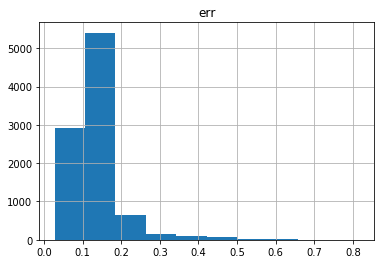

In [46]:
err_df.hist('err')

In [47]:
err_df_high = err_df[err_df['err'] > 0.15]

In [48]:
err_df_high.head()

,phonetic,err
1,O,0.292217
5,y,0.304253
6,i,0.196064
8,i,0.245593
14,A,0.161447


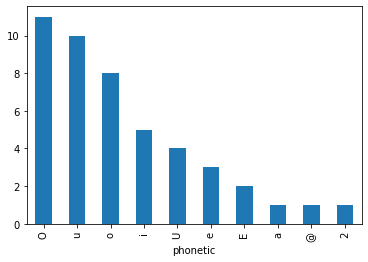

In [49]:
err_df[err_df['err'] > 0.5].groupby('phonetic')['phonetic'].count().sort_values(ascending=False).plot.bar()

In [50]:
err_df_high.groupby('phonetic')['phonetic'].count()

phonetic
2     106
9     189
@     119
A      98
E     250
E:    201
O     192
U     107
a     191
e     216
i     256
o     207
u     231
y     126
Name: phonetic, dtype: int64

## Evaluate each param of each row

In [51]:
se = compute_se(y_test,y_pred)
errs = compute_rmse(y_test,y_pred, axis=1)

In [52]:
df_se = pd.DataFrame(se, columns=["HX","HY","JA","LP","LD","VS","VO","TCX","TCY","TTX","TTY","TBX","TBY","TS1","TS2","TS3","TS4"])

In [53]:
df_se['phonetic'] = z_test
df_se['mean_err'] = errs
df_se['audio'] = a_test

In [54]:
df_se.head()

,HX,HY,JA,LP,LD,VS,VO,TCX,TCY,TTX,TTY,TBX,TBY,TS1,TS2,TS3,TS4,phonetic,mean_err,audio
0,0.117773,0.077305,0.066924,0.086757,0.119798,0.005893,0.333487,0.004245,0.049593,0.043796,0.160527,0.052398,0.074304,0.111977,0.001008,0.032247,0.026956,U,0.111194,"[-0.0036667322, -0.0067870035, -0.009936802, -..."
1,0.402004,0.326394,0.195948,0.134879,0.374650,0.221204,0.456783,0.036066,0.139318,0.229163,0.030990,0.204872,0.228125,0.395959,0.347401,0.518145,0.121751,O,0.292217,"[-0.0077388003, -0.011906635, -0.15257795, -0...."
2,0.049907,0.178747,0.050386,0.109552,0.119077,0.232686,0.286637,0.004917,0.073880,0.052863,0.000451,0.056864,0.131981,0.275934,0.048149,0.049092,0.120624,O,0.138014,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,0.135809,0.066334,0.009185,0.035465,0.053018,0.040019,0.298855,0.044735,0.163779,0.009319,0.108015,0.050581,0.008441,0.198981,0.035514,0.104978,0.008624,U,0.111953,"[0.026149532, 0.034463353, 0.037094187, 0.0368..."
4,0.020397,0.047954,0.148823,0.155678,0.139910,0.070116,0.122367,0.042102,0.038261,0.044839,0.189018,0.070025,0.033955,0.115402,0.054007,0.144176,0.174937,i,0.109335,"[-0.021888198, -0.033991054, -0.042626306, -0...."


In [55]:
df_se[(df_se['phonetic'] == '7') & (df_se['mean_err'] > 0.5)]['TS4'].plot.hist()

TypeError: no numeric data to plot

## EDA audio of testing data 

In [ ]:
df_se_sort = df_se.sort_values('mean_err',ascending=False)
df_se_sort.reset_index(drop=True, inplace=True)

In [ ]:
df_se_sort[df_se_sort['phonetic'] == '&'].head(n=5)

In [ ]:
Audio(df_se_sort['audio'][0], rate=16000)

In [ ]:
df_se_sort[df_se_sort['phonetic'] == '&'].tail(n=5)

In [ ]:
Audio(df_se_sort['audio'][12073], rate=16000)